# Wasserstein GAN - MNIST

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *
from numpy import *
from tqdm import tqdm

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *
import torch.nn
import torch.nn.parallel
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import make_grid

from torch import FloatTensor as FT

In [3]:
#Batchsize, image size and size of noise vector
bs,sz,nz = 64,28,100

## MNIST pytorch

In [4]:
dataloader = DataLoader(datasets.MNIST('/home/hearth/ML/course/deeplearning2/data/mnist/', train=True, download=False,
                                                                          transform=transforms.Compose(
                                                                              [transforms.ToTensor()])),
batch_size=bs, shuffle=True)

In [11]:
transform = transforms.Compose([transforms.Scale(64),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

mnist_data = datasets.MNIST(root='/home/hearth/ML/course/deeplearning2/data/mnist/',
                         train=True,
                         transform=transform,
download=True)

Processing...
Done!


In [30]:
dataloader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=bs,
shuffle=True)

## MNIST keras

In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()


In [5]:
from skimage.transform import rescale, resize, downscale_local_mean

In [6]:
X_train = [(resize(X_train[n].squeeze(), [64, 64])) for n in range(0,60000)]

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [7]:
X_train = np.array(X_train)

In [8]:
X_train.shape

(60000, 64, 64)

In [9]:
#X_train = np.expand_dims(X_train, -1); X_train.shape

In [10]:
preprocess = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

In [11]:
X_train = preprocess(X_train)

In [12]:
X_train.size()

torch.Size([64, 60000, 64])

In [54]:
X_train = X_train.view(60000,1, 64,64)

In [55]:
X_train.size()

torch.Size([60000, 1, 64, 64])

In [8]:
X_train = np.expand_dims(X_train, -1); X_train.shape

(60000, 64, 64, 1)

TypeError: Image data can not convert to float

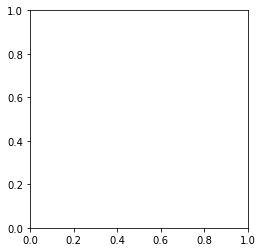

In [74]:
from matplotlib import pyplot as plt
plt.imshow(X_train[66], interpolation='nearest')
plt.show()

In [56]:
#X_traint = torch.from_numpy(X_train)
y_traint = torch.from_numpy(y_train)

In [11]:
X_traint = X_traint.float()

In [57]:
datas = torch.utils.data.TensorDataset(X_train, y_traint)

In [58]:
dataloader = torch.utils.data.DataLoader(datas, bs, True)

## Parameters

In [5]:
n = len(dataloader); n

938

## Generator

In [35]:
 class GAN_G(nn.Module):
        #inF: number of input features/channels
        #outF: number of output channels
        #kS: kernel size
        #strd: strides
        #p: padding
        #uOut: Output height width of upsampling 
        #uOutF: Features output of upsampling
        
        
    def __init__(self, d=128):
        super(GAN_G, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)


    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x
        
        
        
        '''
        def __init__(self, nz=100 ,d=128):
            super(GAN_G, self).__init__()
            
            self.deconv1 = nn.ConvTranspose2d(nz, d*8, kernel_size=4, stride=1, padding=0)
            self.deconv1_bn = nn.BatchNorm2d(d*8)
            self.deconv2 = nn.ConvTranspose2d(d*8, d*4, kernel_size=4, stride=2, padding=1)
            self.deconv2_bn = nn.BatchNorm2d(d*4)
            self.deconv3 = nn.ConvTranspose2d(d*4, d*2, kernel_size=4, stride=2, padding=1)
            self.deconv3_bn = nn.BatchNorm2d(d*2)
            self.deconv4 = nn.ConvTranspose2d(d*2, d, kernel_size=2, stride=2, padding=2)
            self.deconv4_bn = nn.BatchNorm2d(d)
            self.conv = nn.Conv2d(d, 1, kernel_size=1, stride=1, padding=0)

        def forward(self, input):
            x = F.relu(self.deconv1_bn(self.deconv1(input)))
            x = F.relu(self.deconv2_bn(self.deconv2(x)))
            x = F.relu(self.deconv3_bn(self.deconv3(x)))
            x = F.relu(self.deconv4_bn(self.deconv4(x)))
            x = F.tanh(self.conv(x))
            
            return x
        '''

### Discriminator

In [36]:
class GAN_D(nn.Module):
    def __init__(self, d=128):
        super(GAN_D, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)



    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x
    '''def __init__(self, d=128):
        super(GAN_D, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 1, 0)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 2, 1, 0)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x'''
    

### Weight functions

In [37]:
def weights_init(m):
    if isinstance(m,nn.ConvTranspose2d) | isinstance(m, nn.Conv2d): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### Training

In [38]:
netG = GAN_G().cuda()
netG.apply(weights_init);

In [39]:
netD = GAN_D().cuda()
netD.apply(weights_init);

In [40]:
#fake = netG(create_noise(real.size()[0]))

In [41]:
def Var(*parms): return Variable(FT(*parms).cuda())

In [42]:
def create_noise(b): 
    return Variable(FT(b, nz).cuda().normal_(0, 1))

In [43]:
# Input placeholder
input = Var(bs, 100)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = np.array([1]*bs).astype('float32')
one = torch.from_numpy(one).cuda()
one = Variable(one.view(bs))
zero = one * 0

In [44]:
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas=(0.5, 0.999))

In [45]:
G_params = list(netG.parameters())
D_params = list(netD.parameters())

In [46]:
def step_D(v, init_grad):
    err = netD(v)
    err = torch.mean(err)
    err.backward(init_grad)
    return err

In [47]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [48]:
BCE_loss = nn.BCELoss().cuda()

### Train loop

In [49]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in tqdm(range(niter)):
        data_iter = iter(dataloader)
        i = 0
        for x in (dataloader):
            if (x[0].size()[0]!=128): continue
            make_trainable(netD, True)
            #for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
            real = Variable(x[0].cuda())
            netD.zero_grad()
            #print (real.size())
            errD_real = netD(real).squeeze()
            #print (errD_real.size())
            errD_real = BCE_loss(errD_real, one)
            fake = netG(create_noise(real.size()[0]))
            #input.data.resize_(real.size()).copy_(fake.data)
            errD_fake = netD(fake).squeeze()
            errD_fake = BCE_loss(errD_fake, zero)
            errD = errD_real + errD_fake
            errD.backward()
            optimizerD.step()

            make_trainable(netD, False)
            netG.zero_grad()
            errG = netD(netG(create_noise(bs))).squeeze()
            errG = BCE_loss(errG, one)
            optimizerG.step()
            gen_iterations += 1
            if (gen_iterations % 200 == 0):
                print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
                 epoch, niter, gen_iterations, n,
                 errD.cpu().data.numpy(), errG.cpu().data.numpy(), errD_real.cpu().data.numpy(), errD_fake.cpu().data.numpy()))

### Test

In [50]:
%time train(10, True)

  0%|          | 0/10 [00:00<?, ?it/s]

[0/10][200/938] Loss_D: 0.690653 Loss_G: 1.333727 Loss_D_real: 0.337728 Loss_D_fake 0.352924
[0/10][400/938] Loss_D: 0.522719 Loss_G: 1.906509 Loss_D_real: 0.332627 Loss_D_fake 0.190093
[0/10][600/938] Loss_D: 0.271777 Loss_G: 2.170667 Loss_D_real: 0.105759 Loss_D_fake 0.166018
[0/10][800/938] Loss_D: 0.127856 Loss_G: 2.904529 Loss_D_real: 0.065856 Loss_D_fake 0.062000


 10%|█         | 1/10 [00:10<01:36, 10.72s/it]

[1/10][1000/938] Loss_D: 0.072188 Loss_G: 3.377210 Loss_D_real: 0.028382 Loss_D_fake 0.043806
[1/10][1200/938] Loss_D: 0.042813 Loss_G: 3.827496 Loss_D_real: 0.017113 Loss_D_fake 0.025700
[1/10][1400/938] Loss_D: 0.052355 Loss_G: 3.648508 Loss_D_real: 0.018231 Loss_D_fake 0.034124
[1/10][1600/938] Loss_D: 0.029074 Loss_G: 4.137580 Loss_D_real: 0.008684 Loss_D_fake 0.020389
[1/10][1800/938] Loss_D: 0.023351 Loss_G: 4.522669 Loss_D_real: 0.009784 Loss_D_fake 0.013567


 20%|██        | 2/10 [00:21<01:25, 10.74s/it]

[2/10][2000/938] Loss_D: 0.019866 Loss_G: 4.423131 Loss_D_real: 0.003489 Loss_D_fake 0.016377
[2/10][2200/938] Loss_D: 0.017616 Loss_G: 4.669463 Loss_D_real: 0.004072 Loss_D_fake 0.013545
[2/10][2400/938] Loss_D: 0.020501 Loss_G: 5.192545 Loss_D_real: 0.013517 Loss_D_fake 0.006984
[2/10][2600/938] Loss_D: 0.011891 Loss_G: 5.089293 Loss_D_real: 0.001554 Loss_D_fake 0.010337


 30%|███       | 3/10 [00:32<01:14, 10.71s/it]

[2/10][2800/938] Loss_D: 0.015188 Loss_G: 5.001585 Loss_D_real: 0.005713 Loss_D_fake 0.009476
[3/10][3000/938] Loss_D: 0.011190 Loss_G: 5.245535 Loss_D_real: 0.004041 Loss_D_fake 0.007149
[3/10][3200/938] Loss_D: 0.009554 Loss_G: 5.748094 Loss_D_real: 0.004762 Loss_D_fake 0.004792
[3/10][3400/938] Loss_D: 0.006461 Loss_G: 5.898711 Loss_D_real: 0.002162 Loss_D_fake 0.004300
[3/10][3600/938] Loss_D: 0.004687 Loss_G: 6.175596 Loss_D_real: 0.002513 Loss_D_fake 0.002174


 40%|████      | 4/10 [00:42<01:04, 10.70s/it]

[4/10][3800/938] Loss_D: 0.008465 Loss_G: 6.186655 Loss_D_real: 0.004175 Loss_D_fake 0.004290
[4/10][4000/938] Loss_D: 0.012951 Loss_G: 5.115713 Loss_D_real: 0.003966 Loss_D_fake 0.008985
[4/10][4200/938] Loss_D: 0.013249 Loss_G: 5.337472 Loss_D_real: 0.005724 Loss_D_fake 0.007525
[4/10][4400/938] Loss_D: 0.005261 Loss_G: 6.337925 Loss_D_real: 0.001047 Loss_D_fake 0.004214
[4/10][4600/938] Loss_D: 0.002976 Loss_G: 6.575522 Loss_D_real: 0.001012 Loss_D_fake 0.001964


 50%|█████     | 5/10 [00:53<00:53, 10.71s/it]

[5/10][4800/938] Loss_D: 0.002741 Loss_G: 6.748576 Loss_D_real: 0.001018 Loss_D_fake 0.001723
[5/10][5000/938] Loss_D: 0.001709 Loss_G: 7.147183 Loss_D_real: 0.000597 Loss_D_fake 0.001112
[5/10][5200/938] Loss_D: 0.004287 Loss_G: 6.586368 Loss_D_real: 0.002435 Loss_D_fake 0.001852
[5/10][5400/938] Loss_D: 0.008409 Loss_G: 6.461465 Loss_D_real: 0.005494 Loss_D_fake 0.002915
[5/10][5600/938] Loss_D: 0.002577 Loss_G: 7.023255 Loss_D_real: 0.000870 Loss_D_fake 0.001707


 60%|██████    | 6/10 [01:04<00:42, 10.71s/it]

[6/10][5800/938] Loss_D: 0.004766 Loss_G: 6.883982 Loss_D_real: 0.003052 Loss_D_fake 0.001714
[6/10][6000/938] Loss_D: 0.002075 Loss_G: 6.859229 Loss_D_real: 0.000577 Loss_D_fake 0.001498
[6/10][6200/938] Loss_D: 0.002006 Loss_G: 7.303629 Loss_D_real: 0.001148 Loss_D_fake 0.000858
[6/10][6400/938] Loss_D: 0.000820 Loss_G: 7.633137 Loss_D_real: 0.000276 Loss_D_fake 0.000544


 70%|███████   | 7/10 [01:14<00:32, 10.70s/it]

[7/10][6600/938] Loss_D: 0.001235 Loss_G: 7.580830 Loss_D_real: 0.000212 Loss_D_fake 0.001023
[7/10][6800/938] Loss_D: 0.000937 Loss_G: 7.844557 Loss_D_real: 0.000546 Loss_D_fake 0.000391
[7/10][7000/938] Loss_D: 0.000591 Loss_G: 8.100016 Loss_D_real: 0.000249 Loss_D_fake 0.000342
[7/10][7200/938] Loss_D: 0.005165 Loss_G: 8.022005 Loss_D_real: 0.001186 Loss_D_fake 0.003979
[7/10][7400/938] Loss_D: 0.003028 Loss_G: 8.174055 Loss_D_real: 0.000975 Loss_D_fake 0.002053


 80%|████████  | 8/10 [01:25<00:21, 10.72s/it]

[8/10][7600/938] Loss_D: 0.002306 Loss_G: 7.845390 Loss_D_real: 0.001292 Loss_D_fake 0.001014
[8/10][7800/938] Loss_D: 0.003087 Loss_G: 7.593711 Loss_D_real: 0.000983 Loss_D_fake 0.002104
[8/10][8000/938] Loss_D: 0.002702 Loss_G: 7.309375 Loss_D_real: 0.000521 Loss_D_fake 0.002180
[8/10][8200/938] Loss_D: 0.001839 Loss_G: 7.341869 Loss_D_real: 0.000477 Loss_D_fake 0.001361
[8/10][8400/938] Loss_D: 0.019294 Loss_G: 7.748400 Loss_D_real: 0.018063 Loss_D_fake 0.001231


 90%|█████████ | 9/10 [01:36<00:10, 10.72s/it]

[9/10][8600/938] Loss_D: 0.001396 Loss_G: 7.745451 Loss_D_real: 0.000283 Loss_D_fake 0.001112
[9/10][8800/938] Loss_D: 0.001192 Loss_G: 7.987271 Loss_D_real: 0.000433 Loss_D_fake 0.000759
[9/10][9000/938] Loss_D: 0.001114 Loss_G: 8.010815 Loss_D_real: 0.000324 Loss_D_fake 0.000791
[9/10][9200/938] Loss_D: 0.000860 Loss_G: 8.538450 Loss_D_real: 0.000356 Loss_D_fake 0.000503


100%|██████████| 10/10 [01:47<00:00, 10.72s/it]

CPU times: user 1min 39s, sys: 7.73 s, total: 1min 47s
Wall time: 1min 47s


In [54]:
fake = netG(fixed_noise).data.cpu()

In [55]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


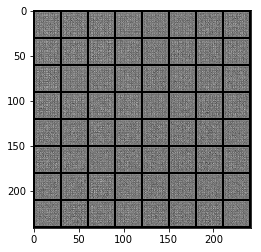

In [56]:
show(torchvision.utils.make_grid(fake))

In [ ]:
one = X_train[9].reshape(28,28)

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(one, interpolation='nearest')
plt.show()

In [ ]:
plt.hist(one.ravel(),256,[0,256]); plt.show()